In [40]:
# read data
file_name = "Estimation Data - Full Model - Monopoly.dta"
file_dir = "..\\data\\Full Model\\"
file_dir_name = file_dir + file_name
data = pd.read_stata(file_dir_name)
# keep advertiser ranks 1, 3
data = data[(data['advertiser_rank'] == 1) | (data['advertiser_rank'] == 3)]
(X, Y, T) = define_xyt(data)
# make T binary (only 0, 1)
T = T.apply(lambda x: 0 if x == 1 else 1)


In [41]:
(X, Y, T) = define_xyt(data)

In [42]:
X

,previous_clicks_all_ads,impression_repeat,previous_clicks,impression_repeat_base_ad,previous_clicks_base_ad,total_visits,visit_s1,visit_s2,visit_s3,visit_s4,...,sub_18,sub_19,sub_20,sub_21,sub_22,sub_23,sub_24,sub_25,sub_26,mobile
0,0,49,0,88,0,101,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,2,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,3,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,7,0,5,0,11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,9,0,12,0,21,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4752300,0,38,0,53,0,101,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4752301,0,4,0,0,0,101,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4752302,0,3,0,7,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4752303,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [50]:

(X, Y, T) = define_xyt(data)
# find best parameters for the m model
best_params = m_model_best_estimator(X, Y)
# estimate the casual forest model
# define the causal forest model
cf = CausalForestDML(
                        model_y=RandomForestRegressor(**best_params),
                        model_t=propensity_model,
                        discrete_treatment='True',
                        criterion='het',
                        n_jobs=n_jobs,
                        n_estimators=100,
                        min_samples_split=1000,
                        max_depth=20,
                        max_samples=0.01,
                        random_state=42,
                        verbose=0   
    )

# tune the model:
start_time = time.perf_counter()

tune_params = cf.tune(
            Y=Y,
            T=T,
            X=X,
            params=cf_param_grid)

finish_time = time.perf_counter()

print(f"finished tuning the model in {finish_time - start_time} seconds")

# fit the model using tuned parameters:
start_time = time.perf_counter()

cf.fit(Y=Y, T=T, X=X, inference="blb", cache_values=True)

finish_time = time.perf_counter()
print(f"finished fitting the model in {finish_time - start_time} seconds")

# save the model
file_name = f"..\\results\\main_scenario\\CF - Rank 1 and 3.pkl"
joblib.dump(cf, file_name)

finished tuning the M model in 25789.990753799997 seconds


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


finished tuning the model in 51120.9092555 seconds


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


finished fitting the model in 18499.9675917 seconds


['..\\results\\main_scenario\\CF - Rank 1 and 3.pkl']

In [37]:
cf =  joblib.load(f'..\\results\\main_scenario\\CF - Rank 1 and 3.pkl')

In [5]:
(X, Y, T) = define_xyt(data)

In [51]:
te_ci = cf.const_marginal_effect_interval(X[0:100000])

In [52]:
te_ci = cf.const_marginal_effect_interval(X[0:100000])
te_h = np.squeeze(te_ci[1])
te_l = np.squeeze(te_ci[0])
te = (te_h + te_l) / 2

In [36]:
te

array([-0.00073823, -0.00180126, -0.00051747, ..., -0.00126662,
       -0.00157573, -0.00075862])

In [37]:
np.sort(te)

array([-0.00359426, -0.00359426, -0.00359426, ...,  0.00048002,
        0.00048801,  0.00052931])

(array([1.5000e+01, 6.0000e+00, 8.1000e+01, 4.5300e+02, 1.4070e+03,
        5.7740e+03, 1.7400e+04, 4.5779e+04, 2.7265e+04, 1.8200e+03]),
 array([-0.68480821, -0.61815682, -0.55150544, -0.48485405, -0.41820267,
        -0.35155128, -0.2848999 , -0.21824851, -0.15159713, -0.08494574,
        -0.01829436]),
 <BarContainer object of 10 artists>)

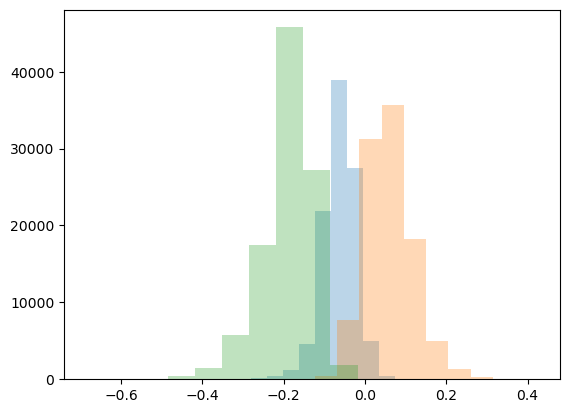

In [57]:
plt.hist(te * 100, alpha=0.3)
plt.hist(te_h * 100, alpha=0.3)
plt.hist(te_l * 100, alpha=0.3)

In [1]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


100%|===================| 99993/100000 [156:21<00:00]        

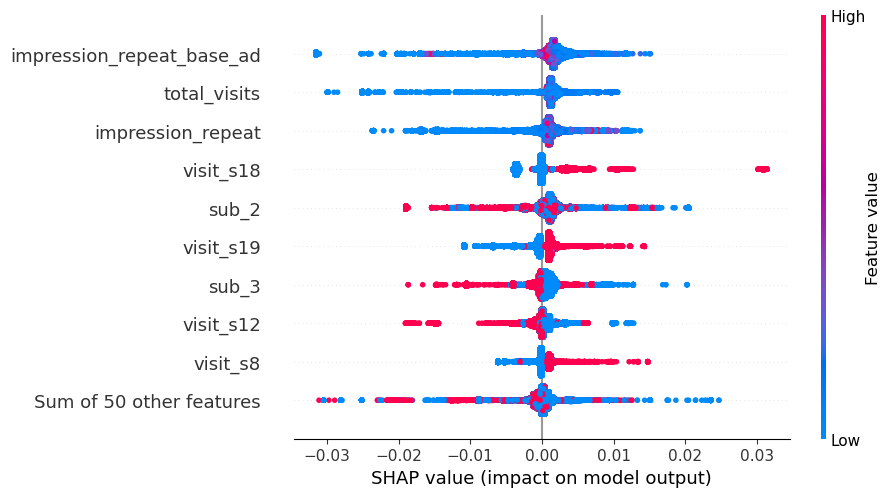

In [19]:
shap_values = cf.shap_values(X[0: 100000])
shap.plots.beeswarm(shap_values['is_clicked']['advertiser_rank_3'])

In [9]:
shap_values['is_clicked']

{'advertiser_rank_3': .values =
 array([[ 9.05011859e-06, -3.80541465e-04, -4.48833205e-06, ...,
          0.00000000e+00,  0.00000000e+00, -1.61775109e-06],
        [ 5.96090095e-06,  8.62201797e-05,  7.80778066e-08, ...,
          0.00000000e+00,  0.00000000e+00, -3.96985993e-06],
        [ 8.77320757e-06,  5.47071739e-04,  1.00643707e-08, ...,
          0.00000000e+00,  0.00000000e+00, -3.43566105e-06],
        ...,
        [ 6.73630767e-06, -1.46719612e-04, -6.33652880e-07, ...,
          0.00000000e+00,  0.00000000e+00, -4.06211217e-06],
        [ 8.32700987e-06, -1.47092532e-04, -3.89294177e-07, ...,
          0.00000000e+00,  0.00000000e+00, -2.81555943e-06],
        [ 1.67397473e-05, -3.62313231e-05, -8.38376210e-07, ...,
          0.00000000e+00,  0.00000000e+00, -2.25410427e-06]])
 
 .base_values =
 array([-0.00037385, -0.00037385, -0.00037385, -0.00037385, -0.00037385,
        -0.00037385, -0.00037385, -0.00037385, -0.00037385, -0.00037385,
        -0.00037385, -0.00037385, 

 99%|===================| 946/951 [02:05<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


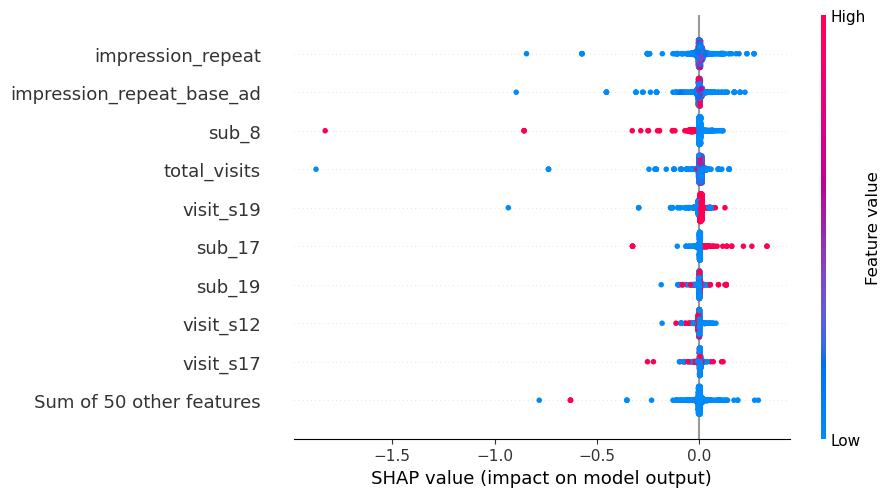

In [51]:
shap_values = cf.shap_values(X[X.index % 5000 == 0])
shap.plots.beeswarm(shap_values['is_clicked']['advertiser_rank_3'])

In [48]:
X

,previous_clicks_all_ads,impression_repeat,previous_clicks,impression_repeat_base_ad,previous_clicks_base_ad,total_visits,visit_s1,visit_s2,visit_s3,visit_s4,...,sub_18,sub_19,sub_20,sub_21,sub_22,sub_23,sub_24,sub_25,sub_26,mobile
0,0,49,0,88,0,101,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,2,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,3,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,7,0,5,0,11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,9,0,12,0,21,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4752300,0,38,0,53,0,101,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4752301,0,4,0,0,0,101,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4752302,0,3,0,7,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4752303,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [21]:
data

,global_token_new,impression_timestamp,publisher_rank,user_visit_no_actual,c_1_s,c_2_s,c_3_s,c_4_s,c_5_s,c_6_s,...,sub_25,sub_26,prop,day,ad,ads_on_page,user_visit_no,mobile,impression_timestamp_s,publisher_rank_s
0,1.0,2012-09-07 18:59:24,16,1.0,0,0,0,0,0,0,...,0,0,0.076182,6,1,5,1,1,1.662664e+12,16
1,1.0,2012-09-08 11:14:27,16,2.0,0,0,0,0,0,0,...,0,0,0.045233,7,1,4,2,1,1.662722e+12,16
2,1.0,2012-09-08 17:46:30,16,3.0,0,0,0,0,0,0,...,0,0,0.076182,7,1,5,3,1,1.662746e+12,16
3,2.0,2012-09-08 03:38:16,889,1.0,0,0,0,0,0,0,...,0,0,0.052213,7,1,14,1,1,1.662695e+12,889
4,3.0,2012-09-07 17:31:04,631,1.0,0,0,0,0,0,0,...,0,0,0.100952,6,1,5,1,1,1.662658e+12,631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4816658,1617554.0,2012-09-08 08:17:49,140,69.0,0,0,0,0,0,0,...,0,0,0.079681,7,1,4,69,1,1.662711e+12,140
4816659,1617554.0,2012-09-08 08:19:14,140,70.0,0,0,0,0,0,0,...,0,0,0.079681,7,1,3,70,1,1.662711e+12,140
4816660,1617554.0,2012-09-08 08:19:34,140,71.0,0,0,0,0,0,0,...,0,0,0.071243,7,1,4,71,1,1.662712e+12,140
4816661,1617555.0,2012-09-08 10:39:36,358,1.0,0,0,0,0,0,0,...,0,0,0.084986,7,1,11,1,1,1.662720e+12,358


In [22]:
cf =  joblib.load(f'..\\results\\split 7\\CF - Rank 20.pkl')

In [23]:
cf

In [24]:
create_chosen_split_ad_vars(data)

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

In [26]:
calc_split_tes(data, split_no=1, user_visit_no=1, ranks_list=config.ranks_list)

finished calculating te's for rank 100 in 45.784664599981625 seconds


In [1]:
ranks_list

NameError: name 'ranks_list' is not defined

In [27]:
data['te']

,global_token_new,impression_timestamp,publisher_rank,user_visit_no_actual,c_1_s,c_2_s,c_3_s,c_4_s,c_5_s,c_6_s,...,chosen_ad_click_dummy_7,chosen_ad_click_dummy_8,chosen_ad_click_dummy_9,chosen_ad_click_dummy_10,chosen_ad_click_dummy_11,chosen_ad_click_dummy_12,chosen_ad_click_dummy_13,chosen_ad_click_dummy_14,chosen_ad_click_dummy_15,num_ads
0,1.0,2012-09-07 18:59:24,16,1.0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2012-09-08 11:14:27,16,2.0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,2012-09-08 17:46:30,16,3.0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,2012-09-08 03:38:16,889,1.0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,2012-09-07 17:31:04,631,1.0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4816658,1617554.0,2012-09-08 08:17:49,140,69.0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4816659,1617554.0,2012-09-08 08:19:14,140,70.0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4816660,1617554.0,2012-09-08 08:19:34,140,71.0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4816661,1617555.0,2012-09-08 10:39:36,358,1.0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
X

,previous_clicks_all_ads,impression_repeat,previous_clicks,impression_repeat_base_ad,previous_clicks_base_ad,total_visits,visit_s1,visit_s2,visit_s3,visit_s4,...,sub_18,sub_19,sub_20,sub_21,sub_22,sub_23,sub_24,sub_25,sub_26,mobile
0,0,49,0,88,0,101,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,2,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,3,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,7,0,5,0,11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,9,0,12,0,21,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4752300,0,38,0,53,0,101,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4752301,0,4,0,0,0,101,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4752302,0,3,0,7,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4752303,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [30]:
file_name = f"Estimation Data by Subject - Last Two Days Binary - split 7.dta"
file_dir = "..\\data\\"
file_dir_name = file_dir + file_name
data1 = pd.read_stata(file_dir_name)

In [34]:
(X_1, Y, T) = define_xyt(data1)

In [35]:
X_1

,impression_repeat,previous_clicks,previous_clicks_all_ads,impression_repeat_base_ad,previous_clicks_base_ad,total_visits,visit_s1,visit_s2,visit_s3,visit_s4,...,sub_20,sub_21,sub_22,sub_23,sub_24,sub_25,sub_26,mobile,rand,split
0,2,0,0,0,0,11,0,0,0,0,...,0,0,0,0,0,0,0,0,0.313200,7.0
1,5,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0.192408,7.0
2,28,0,0,0,0,101,1,1,0,0,...,0,0,0,0,0,0,0,1,0.195140,7.0
3,55,0,0,0,0,51,0,0,0,1,...,0,0,0,0,0,0,0,1,0.290445,7.0
4,57,0,0,0,0,101,1,1,0,1,...,0,0,0,0,0,0,0,1,0.488210,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13655686,1,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,1,0.003640,7.0
13655687,3,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0.330642,7.0
13655688,1,0,0,0,0,11,0,0,0,0,...,0,0,0,0,0,0,1,1,0.056216,7.0
13655689,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0.340954,7.0


In [33]:
data1

,publisher_subject,advertiser_rank,is_clicked,impression_repeat,previous_clicks,previous_clicks_all_ads,impression_repeat_base_ad,previous_clicks_base_ad,total_visits,event_no,...,sub_21,sub_22,sub_23,sub_24,sub_25,sub_26,prop,mobile,rand,split
0,architecture,1,0,2,0,0,0,0,11,13492683.0,...,0,0,0,0,0,0,0.021221,0,0.313200,7.0
1,architecture,1,0,5,0,0,0,0,1,7795274.0,...,0,0,0,0,0,0,0.021221,1,0.192408,7.0
2,architecture,1,0,28,0,0,0,0,101,12118237.0,...,0,0,0,0,0,0,0.021221,1,0.195140,7.0
3,architecture,1,0,55,0,0,0,0,51,2403945.0,...,0,0,0,0,0,0,0.021221,1,0.290445,7.0
4,architecture,1,0,57,0,0,0,0,101,7459171.0,...,0,0,0,0,0,0,0.021221,1,0.488210,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13655686,work,1186,0,1,0,0,0,0,1,11819221.0,...,0,0,0,0,0,1,0.000238,1,0.003640,7.0
13655687,work,1197,0,3,0,0,0,0,1,7042354.0,...,0,0,0,0,0,1,0.000011,1,0.330642,7.0
13655688,work,1279,0,1,0,0,0,0,11,13675272.0,...,0,0,0,0,0,1,0.000079,1,0.056216,7.0
13655689,work,1279,0,1,0,1,0,0,1,10879640.0,...,0,0,0,0,0,1,0.000079,1,0.340954,7.0
